In [1]:
import numpy as np
import time
from scipy.optimize import differential_evolution, minimize, dual_annealing
import matplotlib.pyplot as plt
import concurrent.futures
import threading, multiprocessing

import sys 
sys.path.append("../")  
import minionpy as mpy
import minionpy.test_functions as mpytest
import time

# Minimizing Basic Functions

In this section, we minimize basic functions such as Sphere, Rosenbrock, and Rastrigin. The search space is shifted to prevent algorithms from converging near the origin, as some algorithms tend to favor that region.


In [2]:
def sphere(x) : 
    x =np.asarray(x)-1
    return 100+np.sum(x**2)

def rosenbrock(x):
    #if x[0]<-1 or x[0]>1 : print(x, "bound violated")
    x = np.asarray(x)-5.0
    return 100+np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def rastrigin(x):
    x = np.asarray(x)-1.0
    A = 10
    return 100+A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

#remember that in minion, objective function must be vectorized. Suppose you want to 
func = rosenbrock
def objective_function(X) : 
    """ 
    Here, X is a list of x, where x is an input vector. 
    """
    return [func(x) for x in X] 

#Now minimize the function using minion 
dimension = 5 #set dimension of the problem
maxevals = 1000 #number of function calls
x0 = [[0.0]*dimension] # initial guesses

min = mpy.Minimizer(func=objective_function, x0=x0, bounds=[(-1, 1)]*dimension, algo="ARRDE", relTol=0.0, 
                    maxevals=10000, callback=None, seed=None, options={"minimum_population_size":4})
result = min.optimize()
print("The minimum of the function is ", "\n\t x : ", result.x, "\n\t f(x) : ", result.fun)

The minimum of the function is  
	 x :  [0.9999999999999998, 0.9999999999999996, 0.9999999999999997, 1.0, 0.9999999999999999] 
	 f(x) :  160200.0


# Using Basic Test Functions

Minionpy provides a variety of test functions for evaluating optimization algorithms. The dictionary `testFunctionDict` below contains some of the fundamental functions available. Many of these functions have a global minimum at the origin, which can be problematic since some algorithms naturally converge toward it. To address this issue, CEC benchmark functions apply rotation and shifting to these basic functions, making them more representative of real-world optimization scenarios.  

The test functions in `minionpy.test_functions` are vectorized by default. They accept input as a 2D NumPy array.


In [3]:
testFunctionDict = {
    "sphere" : mpytest.sphere, 
    "rosenbrock" : mpytest.rosenbrock, 
    "rastrigin" : mpytest.rastrigin, 
    "schaffer2" : mpytest.schaffer2, 
    "griewank" : mpytest.griewank, 
    "ackley" : mpytest.ackley, 
    "zakharov" : mpytest.zakharov, 
    "bent_cigar" : mpytest.bent_cigar, 
    "levy" : mpytest.levy, 
    "discus" : mpytest.discus, 
    "drop_wave" : mpytest.drop_wave, 
    "goldstein_price" : mpytest.goldstein_price, 
    "exponential" : mpytest.exponential,
    "quartic" : mpytest.quartic, 
    "hybrid_composition1" : mpytest.hybrid_composition1,
    "hybrid_composition2" : mpytest.hybrid_composition2,
    "hybrid_composition3" : mpytest.hybrid_composition3,
    "happy_cat"  : mpytest.happy_cat, 
    "michalewics" : mpytest.michalewicz,
    "scaffer6" : mpytest.scaffer6, 
    "hcf" : mpytest.hcf, 
    "grie_rosen" : mpytest.grie_rosen,
    "dixon_price" : mpytest.dixon_price, 
    "eosom" : mpytest.easom, 
    "hgbat" : mpytest.hgbat, 
    "styblinski_tang" : mpytest.styblinski_tang, 
    "step" : mpytest.step, 
    "weierstrass" : mpytest.weierstrass, 
    "sum_squares" : mpytest.sum_squares
}

The performance of different algorithms to minimize these functions can be compared as shown below.

In [4]:
dimension = 10
maxevals = 10000
np.random.seed(1)
shift = 10 * np.random.rand(dimension)  # Shift randomly
bounds = [(-10, 10)] * dimension
x0 = [10 * np.random.rand(dimension)] # Initial guesses
np.random.seed(None)

for func_name in testFunctionDict:
    #if func_name not in ["schaffer2", "ackley", "rastrigin", "rosenbrock"]:
    #    continue  # Minimize only these functions; comment this line to compare all test functions

    print(f"Function: {func_name}")

    N = 0

    def objective_function(X):
        """Shifted objective function for minimization."""
        global N
        X = np.array(X) - shift  # Shift the space
        N += len(X)
        return testFunctionDict[func_name](X)

    def objective_function_scipy(X):
        """Objective function for SciPy optimizers."""
        global N
        N += 1
        return testFunctionDict[func_name]([X])[0]

    algoList = [
        "DE", "ABC", "LSHADE", "LSHADE_cnEpSin", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP",
        "ARRDE", "GWO_DE", "NelderMead", "DA", "L_BFGS_B", "PSO", "DMSPSO", "SPSO2011", "CMAES", "BIPOP_aCMAES"
    ]
    

    for algo in algoList:
        t_start = time.time()
        N = 0
        result = mpy.Minimizer(
            func=objective_function, x0=x0, bounds=bounds, algo=algo, 
            relTol=0.0, maxevals=maxevals, callback=None, seed=None,
            options={"population_size": 0}
        ).optimize()
        elapsed_time = time.time() - t_start
        print(f"\tAlgorithm: {algo:<18} f(x): {result.fun:<15.8g} Elapsed: {elapsed_time:.3f} s")

    # Compare to SciPy algorithms
    algorithms_scipy = [
        ("Scipy Nelder-Mead", minimize, {"x0": x0[0], "method": "Nelder-Mead", 
                                         "bounds": bounds, "options": {"maxfev": maxevals, "adaptive": True}}),
        ("Scipy L-BFGS-B", minimize, {"x0": x0[0], "method": "L-BFGS-B", 
                                      "options": {"maxfun": maxevals}, "bounds": bounds}),
        ("Scipy DA", dual_annealing, {"bounds": bounds, "maxfun": maxevals, "x0": x0[0], "no_local_search": False})
    ]

    for name, func, kwargs in algorithms_scipy:
        t_start = time.time()
        N = 0
        result = func(objective_function_scipy, **kwargs)
        elapsed_time = time.time() - t_start
        print(f"\tAlgorithm: {name:<18} f(x): {result.fun:<15.8g} Elapsed: {elapsed_time:.3f} s")

    print("")


Function: sphere
	Algorithm: DE                 f(x): 6.4594316e-07   Elapsed: 0.024 s
	Algorithm: ABC                f(x): 1.0122429e-06   Elapsed: 0.015 s
	Algorithm: LSHADE             f(x): 4.8582737e-10   Elapsed: 0.029 s
	Algorithm: LSHADE_cnEpSin     f(x): 6.3487577e-11   Elapsed: 0.023 s
	Algorithm: JADE               f(x): 9.2561239e-17   Elapsed: 0.024 s
	Algorithm: jSO                f(x): 3.23311e-11     Elapsed: 0.029 s
	Algorithm: j2020              f(x): 2.5152134e-12   Elapsed: 0.096 s
	Algorithm: LSRTDE             f(x): 7.735322e-11    Elapsed: 0.015 s
	Algorithm: NLSHADE_RSP        f(x): 3.8201629e-10   Elapsed: 0.016 s
	Algorithm: ARRDE              f(x): 2.2758254e-25   Elapsed: 0.024 s
	Algorithm: GWO_DE             f(x): 3.8637342e-06   Elapsed: 0.016 s
	Algorithm: NelderMead         f(x): 4.6709368e-30   Elapsed: 0.031 s
	Algorithm: DA                 f(x): 4.7770251e-15   Elapsed: 0.066 s
	Algorithm: L_BFGS_B           f(x): 8.5184112e-31   Elapsed: 0.000 s
	Al

# Minimizing Expensive Functions with Multithreading/Multiprocessing

When the objective function is expensive to evaluate, multithreading can be used to speed up the calculation of the vectorized objective function. However, this requires that the objective function is **thread-safe**. 

If the objective function is not thread-safe, then **multiprocessing** can be used instead. This approach allows parallel execution across separate processes, which avoids the potential issues with thread safety.


## Example to vectorize a thread-safe function using multithreading and multiprocessing
If the function is thread-safe to call cuncurrently, then we can safely use concurrent.futures.ThreadPoolExecutor (for multithreading) or concurrent.futures.ProcessPoolExecutor (for multiproceesing) directly. 

In [5]:
# Function to minimize (expensive to evaluate)
def func(x):
    ret = rosenbrock(x)
    time.sleep(0.01)  # Simulate expensive computation
    return ret

# Parallel execution setup
Nthreads = 8
use_threads = True  # Toggle between ThreadPoolExecutor and ProcessPoolExecutor

if use_threads:
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=Nthreads)
else:
    executor = concurrent.futures.ProcessPoolExecutor(max_workers=Nthreads)

def objective_function(X):
    return list(executor.map(func, X))  # Batch evaluation in parallel

# Optimization problem settings
dimension = 10
maxevals = 1000
x0 = [[3.0] * dimension]
bounds = [(-10, 10)] * dimension

# List of algorithms to test
algorithms = {
    "ARRDE": {"options": None},
    "L_BFGS_B": {"options": {"func_noise_ratio": 0.0, "N_points_derivative": 1}},
    "DA": {"options": None}
}

print("\nOptimization Results:")
print("=" * 100)

# Run optimizations using Minion
for algo, settings in algorithms.items():
    start_time = time.time()
    minimizer = mpy.Minimizer(
        func=objective_function,
        x0=x0,
        bounds=bounds,
        algo=algo,
        relTol=0.0,
        maxevals=maxevals,
        callback=None,
        seed=None,
        options=settings["options"]
    )
    result = minimizer.optimize()
    elapsed = time.time() - start_time

    print(f"Algo : {algo:<30} | f(x) = {result.fun:<20.8g} | Elapsed: {elapsed:.2f} sec")

# Compare with SciPy optimizers (without multithreading)
for algo, opt_func in [
    ("Scipy Dual Annealing", dual_annealing),
    ("Scipy L-BFGS-B", minimize)
]:
    start_time = time.time()
    if algo == "Scipy Dual Annealing":
        result = opt_func(func, bounds=bounds, maxfun=maxevals, no_local_search=False, x0=x0[0])
    else:
        result = opt_func(func, x0=x0[0], method="L-BFGS-B", options={"maxfun": maxevals}, bounds=bounds)

    elapsed = time.time() - start_time
    print(f"Algo : {algo:<30} | f(x) = {result.fun:<20.8g} | Elapsed: {elapsed:.2f} sec")

print("=" * 100)

# Shutdown executor gracefully
executor.shutdown()




Optimization Results:
Algo : ARRDE                          | f(x) = 112.52055            | Elapsed: 1.62 sec
Algo : L_BFGS_B                       | f(x) = 100                  | Elapsed: 1.68 sec
Algo : DA                             | f(x) = 100                  | Elapsed: 3.70 sec
Algo : Scipy Dual Annealing           | f(x) = 100                  | Elapsed: 10.34 sec
Algo : Scipy L-BFGS-B                 | f(x) = 100                  | Elapsed: 4.42 sec


The algorithms implemented in Minion (ARRDE, L-BFGS-B, and Dual Annealing) significantly outperform their SciPy counterparts in speed. This performance improvement stems from Minion’s efficient numerical derivative computation, which batches function evaluations—an approach that greatly benefits minion's L-BFGS-B and Dual Annealing. Note that dual annealing use L-BFGS-B for local search.

------------------

## Using `minionpy.Thread_Parallel` to vectorize non-thread-safe member function

In the previous example, we demonstrated how to minimize a thread-safe function. However, in real-world scenarios, the objective function is often a method of a class, and class methods are typically **not thread-safe**. In this example, we demonstrate how to minimize a **non-thread-safe function** using the `Thread_Parallel` class. This approach ensures proper parallelization even when the objective function modifies internal state, which can lead to race conditions in a multi-threaded environment.

### 1. Define the Class with `objective_function`

First, define a class that includes the `objective_function`. This function should accept a list of floats as input and return a single float as the output. In this example, the `objective_function` modifies an internal state, which makes it non-thread-safe. We will show how the minionpy `Thread_Parallel` class manages the parallel execution of such functions while ensuring thread isolation.

In [6]:
class Objective : 
    """ 
    This illustrate a class with a non-thread-safe self.objective_function
    """
    def __init__ (self, b) : 
        self.A=None  # There is a now class member that will be modified when self.objective_function is called.
        self.b = b
    
    def update_A(self, x) : 
        self.A = self.b*np.sin(x) #modify self.A
        time.sleep(0.05)  #simulate an expensive function

    def objective_function(self, x) : 
        self.update_A(x)
        ret = np.sum(self.A*x)  
        #print(x, ret)
        return ret

### 2. Define the Thread_Parallel object

In [7]:
# Here, we vectorize `Objective.objective_function` using 8 threads, with the `b` parameter in the Objective class constructor set to `0.2`.
t_parallel = mpy.Thread_Parallel(8, Objective, 0.2) 

#You can test the vectorization as follows : 
X = np.random.rand(8, 8) #randomly creates 6 vectors of dimension 8
start = time.time()
res = t_parallel(X) 
print("Vectorization using Thread_Parallel : \n\t", res) 
print("Elapsed  : ", time.time()-start, "\n")

obj=Objective(b=0.2)
start = time.time()
res2 = [obj.objective_function(x) for x in X]
print("Calling the function sequentially : \n\t", res2) 
print("Elapsed  : ", time.time()-start, "\n")

#test if res and res2 are exactly the same 
print(np.array(res).all() == np.array(res2).all())

Vectorization using Thread_Parallel : 
	 [0.5661370676468356, 0.7775659672127234, 0.4229914027614482, 0.5303959761143511, 0.3761453211372047, 0.5522159710759306, 0.38951343396507465, 0.556718173281366]
Elapsed  :  0.05110669136047363 

Calling the function sequentially : 
	 [0.5661370676468356, 0.7775659672127234, 0.4229914027614482, 0.5303959761143511, 0.3761453211372047, 0.5522159710759306, 0.38951343396507465, 0.556718173281366]
Elapsed  :  0.40199875831604004 

True


### 3. Minimize using one of minionpy algorithms

In [8]:
dimension = 8 #set dimension of the problem
maxevals = 1000 #number of function calls
x0 = [[3.0]*dimension] # initial guess
bounds = [(-10, 10)]*dimension
algo = "ARRDE" 

now = time.time()
min = mpy.Minimizer(func=t_parallel, x0=x0, bounds=bounds, algo=algo, relTol=0.0,
                     maxevals=maxevals, callback=None, seed=None, options={"population_size": 0})
result = min.optimize()
elapsed= time.time()-now
print("Algo : ",algo, "\n\t x : ", result.x, "\n\t f(x) : ", result.fun, "\n\t Elapsed: ", elapsed, " seconds\n")
print("Test function value  : ", Objective(b=0.2).objective_function(np.asarray(result.x)))

Algo :  ARRDE 
	 x :  [-4.8745482242483, 4.2532696314673295, 4.636776364023326, -4.935053006852719, -4.893801687256062, 4.2541727836417795, -4.5347783796462, 5.555873294650024] 
	 f(x) :  -6.969264085741495 
	 Elapsed:  7.983117580413818  seconds

Test function value  :  -6.969264085741495


We can observe that the minimum found by the ARRDE algorithm corresponds to the correct function value. But what happens if we use ThreadPoolExecutor without considering the thread-safety of the objective_function method?

In [9]:
obj = Objective(b=0.2)
executor = concurrent.futures.ThreadPoolExecutor(max_workers=8)

def vectorize_obj(X) : 
    ret = list(executor.map(obj.objective_function, np.asarray(X)))
    return ret

now = time.time()
min = mpy.Minimizer(func=vectorize_obj, x0=x0, bounds=bounds, algo=algo, relTol=0.0, maxevals=maxevals, callback=None, seed=None, options=None)
result = min.optimize()
elapsed= time.time()-now
print("Algo : ",algo, "\n\t x : ", result.x, "\n\t f(x) : ", result.fun, "\n\t Elapsed: ", elapsed, " seconds\n")
print("Test function value  :", obj.objective_function(np.asarray(result.x)))
executor.shutdown(wait=True)

Algo :  ARRDE 
	 x :  [-4.9085261023046725, 9.855798668604562, 5.326274488405682, -9.870938023916791, -6.328512976971076, -9.748500557841409, -9.603724177180414, 9.362136235173324] 
	 f(x) :  -7.418963223826018 
	 Elapsed:  7.983393907546997  seconds

Test function value  : -4.296564752042263


We can see that the function value of the minimum is not the same as the actual function value. 

## Using multiprocessing for non-thread-safe functions using `minionpy.Process_Parallel`

If multiprocessing is preferred over multithreading—whether to bypass the Global Interpreter Lock (GIL) or to ensure clean separation of data during objective function vectorization—`minionpy` provides the `Process_Parallel` feature. It follows the same usage rules as `Thread_Parallel`. When using `Process_Parallel`, a predefined number of reusable processes are created, each with its own instance of the class object.

In [10]:
p_parallel = mpy.Process_Parallel(8, Objective, 0.2) 

#You can test the vectorization as follows : 
start = time.time()
X = np.random.rand(8, 6) #randomly creates 6 vectors of dimension 8
res = p_parallel(X) 
print("Vectorization using Process_Parallel : \n\t", res) 
print("Elapsed  : ", time.time()-start, "\n")

obj=Objective(b=0.2)
start = time.time()
res2 = [obj.objective_function(x) for x in X]
print("Calling the function sequentially : \n\t", res2) 
print("Elapsed  : ", time.time()-start, "\n")

#test if res and res2 are exactly the same 
print(np.array(res).all() == np.array(res2).all())

Vectorization using Process_Parallel : 
	 [0.5304442646984987, 0.20451016023783655, 0.10655265370931162, 0.2714407459077475, 0.2980790126820181, 0.315356307197812, 0.19289203891937706, 0.440687150822349]
Elapsed  :  0.12279987335205078 

Calling the function sequentially : 
	 [0.5304442646984987, 0.20451016023783655, 0.10655265370931162, 0.2714407459077475, 0.2980790126820181, 0.315356307197812, 0.19289203891937706, 0.440687150822349]
Elapsed  :  0.4028041362762451 

True


In [11]:
dimension = 8 #set dimension of the problem
maxevals = 1000 #number of function calls
x0 = [[3.0]*dimension] # initial guess
bounds = [(-10, 10)]*dimension
algo = "ARRDE" 

now = time.time()
min = mpy.Minimizer(func=p_parallel, x0=x0, bounds=bounds, algo=algo, relTol=0.0,
                     maxevals=maxevals, callback=None, seed=None, options={"population_size": 0})
result = min.optimize()
elapsed= time.time()-now
print("Algo : ",algo, "\n\t x : ", result.x, "\n\t f(x) : ", result.fun, "\n\t Elapsed: ", elapsed, " seconds\n")
print("Test function value  : ", Objective(b=0.2).objective_function(np.asarray(result.x)))

Algo :  ARRDE 
	 x :  [-5.292044833018368, 4.166986458579692, 4.488022614476481, 5.0228088678480765, 5.23266594020464, -4.826695879758527, -1.209896518319117, 4.336840773972577] 
	 f(x) :  -5.877285885951624 
	 Elapsed:  8.18626880645752  seconds

Test function value  :  -5.877285885951624


# Algorithm Comparisons Using CEC Benchmark Problems

We can compare the performance of different optimization algorithms by evaluating them on benchmark problems from the Congress on Evolutionary Computation (CEC) competition. The Minion library provides implementations of benchmark problems from the following CEC years: 2011, 2014, 2017, 2019, 2020, and 2022.

- **CEC2014 and CEC2017**: These benchmarks contain 30 problems, implemented for dimensions 10, 20, 30, 50, and 100.
- **CEC2019**: This set includes 10 problems with varying dimensions.
- **CEC2020**: It contains 10 problems with dimensions 5, 10, 15, and 20.
- **CEC2022**: This set consists of 12 problems with dimensions 10 and 20.

CEC problems typically include a variety of function types:
- **Basic functions** (e.g., Rosenbrock, Rastrigin),
- **Hybrid functions** (new functions constructed by combining basic functions, where each component is evaluated using a different basic function),
- **Composite functions** (linear combinations of basic functions, where the coefficients are also functions of the input vector).

These functions are often shifted and rotated to introduce additional complexity.

CEC2011 consists of a set of real-world problems, idealized and simplified for the competition. It contains 22 problems of varying dimensions. Note that, for CEC2011, MATLAB must be installed on the system. An example of how to minimize CEC2011 problems can be found in `examples/cec_11.py`.


In [12]:
import threading
import concurrent.futures

# This script minimizes CEC benchmark problems, repeated for NRuns times.

# Global results variable
results = []
results_lock = threading.Lock()

def test_optimization(func, bounds, dimension, func_name, Nmaxeval, seed):
    """Runs optimization algorithms on a given function and stores the results."""
    global results
    result = {
        "Dimensions": dimension,
        "Function": func_name
    }
    
    bounds_list = [bounds] * dimension
    x0 = [[0.0 for _ in range(dimension)]]

    print(f"\nRunning optimization for {func_name} (Dimension: {dimension})")
    print("=" * 60)

    for algo in algos:
        res = mpy.Minimizer(
            func, bounds_list, x0=x0, relTol=0.0, algo=algo, 
            maxevals=Nmaxeval, callback=None, seed=None, 
            options={
                "population_size"   : 0, #2*dimension, 
                "func_noise_ratio"  :  0.0, 
                "N_points_derivative": 1, 
                "bound_strategy" : "none"
                }
        ).optimize()
        result[algo] = res.fun
        print(f"  {algo:<15} f(x): {res.fun:<20.8g}")

    def func_scipy(par):
        return func([par])[0]
    
    # SciPy Optimizers
    scipy_algorithms = [
        ("Scipy L-BFGS-B", minimize, {"x0": x0[0], "method": "L-BFGS-B", "options": {"maxfun": Nmaxeval}, "bounds": bounds_list}),
         ("Scipy Nelder-Mead", minimize, {"x0": x0[0], "method": "Nelder-Mead", "bounds": bounds_list, "options": {"maxfev": Nmaxeval, "adaptive": True}}),
        ("Scipy DA", dual_annealing, {"bounds": bounds_list, "maxfun": Nmaxeval, "no_local_search": False, "x0": x0[0]}),
    ]

    for name, func_opt, kwargs in scipy_algorithms:
        res = func_opt(func_scipy, **kwargs)
        result[name] = res.fun
        print(f"  {name:<15} f(x): {res.fun:<20.8g}")

    with results_lock:
        results.append(result)

    print("-" * 60)

def run_test_optimization(j, dim, year=2017, seed=None):
    """Runs the optimization for a specific function and CEC benchmark year."""
    cec_func_classes = {
        2014: mpy.CEC2014Functions,
        2017: mpy.CEC2017Functions,
        2019: mpy.CEC2019Functions,
        2020: mpy.CEC2020Functions,
        2022: mpy.CEC2022Functions
    }
    
    if year not in cec_func_classes:
        raise Exception("Unknown CEC year.")
    
    cec_func = cec_func_classes[year](function_number=j, dimension=dim)
    test_optimization(cec_func, (-100, 100), dim, f"func_{j}", Nmaxeval, seed)

# List of algorithms to be tested
algos = [
      "DE", "ABC", "LSHADE", "LSHADE_cnEpSin", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP",
        "ARRDE", "GWO_DE", "NelderMead", "DA", "L_BFGS_B", "PSO", "DMSPSO", "SPSO2011", "CMAES", "BIPOP_aCMAES"
]

Nmaxeval = 200000  # Maximum number of function evaluations
dimension = 20
NRuns = 1  # Number of repetitions
year = 2022  # CEC benchmark year

# Function numbers for each CEC year
func_numbers_dict = {
    2022: list(range(1, 13)),
    2020: list(range(1, 11)),
    2019: list(range(1, 11)),
    2017: list(range(1, 31)),
    2014: list(range(1, 31)),
}
func_numbers = func_numbers_dict[year]

# Run optimizations using multi-threading
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    futures = [
        executor.submit(run_test_optimization, j, dimension, year, k)
        for k in range(NRuns)
        for j in func_numbers
    ]
    concurrent.futures.wait(futures)
    
    for f in futures:
        f.result()




Running optimization for func_1 (Dimension: 20)
  DE              f(x): 300                 
  ABC             f(x): 42484.882           
  LSHADE          f(x): 300                 
  LSHADE_cnEpSin  f(x): 300                 
  JADE            f(x): 300                 
  jSO             f(x): 300                 
  j2020           f(x): 300.00003           
  LSRTDE          f(x): 300                 
  NLSHADE_RSP     f(x): 300                 
  ARRDE           f(x): 300                 
  GWO_DE          f(x): 302.76135           
  NelderMead      f(x): 300                 
  DA              f(x): 300                 
  L_BFGS_B        f(x): 300                 
  PSO             f(x): 300                 
  DMSPSO          f(x): 300                 
  SPSO2011        f(x): 300                 
  CMAES           f(x): 300                 
  BIPOP_aCMAES    f(x): 300                 
  Scipy L-BFGS-B  f(x): 300                 
  Scipy Nelder-Mead f(x): 300                 
  Sc

# Example of using minion/py in curve fitting problems


Here, an example of using minion to minimize an objective function related to a curve fitting problem is demonstrated. 
The idea is first to define the data generation model, generate the data, fit the model, and report the result. 

## Polynomial Fitting Problems
In this problem, we try fit a polynomial from a set of data. Specifically, a set of points ($\{(x_i, y_i) \mid i = 1, 2, \dots, N\}$) with $x \in [0, 1]$ is generated according to:
$$
    f(x, a) = \sum_{j=0}^{D-1} a_j x^j
$$
Given the coefficients $a_j$ that generate the data, the goal is to reproduce the data points by minimizing the objective function:
$$
    L = \frac{1}{N}\sum_{i=1}^N \left(y_i - f(x_i, a)\right)^2 
$$



Optimization Results:
DE                            : f(x) = 3.4676234e-07       
ABC                           : f(x) = 0.0056994221        
LSHADE                        : f(x) = 4.0557789e-10       
LSHADE_cnEpSin                : f(x) = 3.3043359e-14       
JADE                          : f(x) = 5.251496e-08        
jSO                           : f(x) = 9.774338e-11        
j2020                         : f(x) = 8.4535903e-05       
LSRTDE                        : f(x) = 1.4773705e-12       
NLSHADE_RSP                   : f(x) = 7.1946723e-06       
ARRDE                         : f(x) = 4.2782791e-09       
GWO_DE                        : f(x) = 1.2315456e-05       
NelderMead                    : f(x) = 4.0539659e-15       
DA                            : f(x) = 2.521779e-05        
L_BFGS_B                      : f(x) = 7.2866825e-07       
PSO                           : f(x) = 3.5313431e-05       
DMSPSO                        : f(x) = 2.6368825e-05       
SPSO2011         

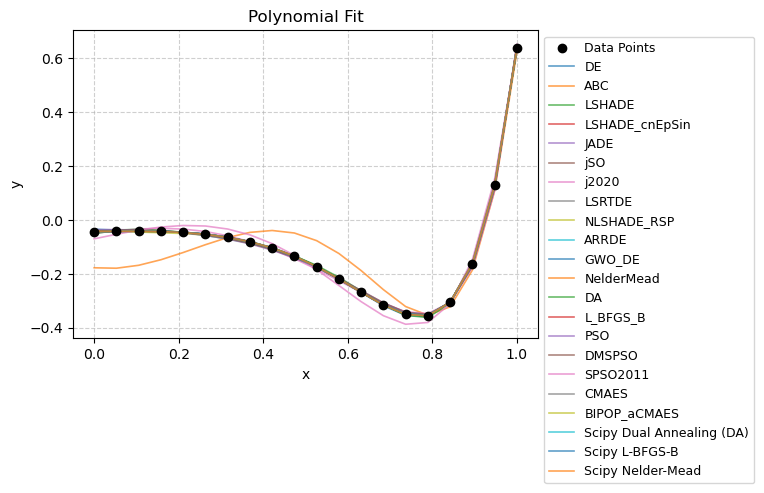

In [13]:
# Step 1: Generate Data Points from a Polynomial
dimension = 10  # Number of free parameters (polynomial degree is dimension - 1)
np.random.seed(8)  # For reproducibility

# True polynomial coefficients (random values)
true_coefficients = [np.random.uniform(-1.0, 1.0) * (1.0 ** i) for i in range(dimension)]

# Generate data points
x_data = np.linspace(0.0, 1, dimension + 10)
y_data = np.polyval(true_coefficients, x_data)

# Step 2: Define the Polynomial Model
def polynomial_model(x, coefficients):
    """Evaluate a polynomial at x given the coefficients."""
    return np.polyval(coefficients, x)

# Step 3: Define the Objective Function
def objective_function(coefficients):
    """Compute the mean squared error between the polynomial model and data points."""
    y_pred = polynomial_model(x_data, coefficients)
    return np.mean((y_data - y_pred) ** 2)

def objective_function_vect(X):
    """Vectorized version of the objective function for batch optimization."""
    return [objective_function(x) for x in X]

# Optimization Settings
bounds = [(-10, 10)] * dimension
Nmaxeval = 20000
algos = [
      "DE", "ABC", "LSHADE", "LSHADE_cnEpSin", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP",
        "ARRDE", "GWO_DE",  "NelderMead", "DA", "L_BFGS_B", "PSO", "DMSPSO", "SPSO2011", "CMAES", "BIPOP_aCMAES"
]

# Step 4: Minimize the Objective Function and Plot Results
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label="Data Points", color="black", marker="o", zorder=3)

x0 = [[0.0 for _ in range(dimension)]]

print("\nOptimization Results:")
print("=" * 50)

# Run Optimization with Custom Algorithms
for algo in algos:
    res = mpy.Minimizer(
        objective_function_vect, bounds, x0=x0, relTol=0.0,
        algo=algo, maxevals=Nmaxeval, callback=None, seed=0,
        options={
            "population_size": 0, 
            "func_noise_ratio"  :  0.0, 
            "N_points_derivative": 1}
    ).optimize()

    print(f"{algo:<30}: f(x) = {res.fun:<20.8g}")
    plt.plot(x_data, polynomial_model(x_data, res.x), label=algo, linewidth=1.2, alpha=0.7)

# Run SciPy Optimizers
scipy_algorithms = [
    ("Scipy Dual Annealing (DA)", dual_annealing, {"bounds": bounds, "maxfun": Nmaxeval, "no_local_search": False, "x0": x0[0]}),
    ("Scipy L-BFGS-B", minimize, {"x0": x0[0], "bounds": bounds, "method": "L-BFGS-B", "options": {"maxfun": Nmaxeval}}),
    ("Scipy Nelder-Mead", minimize, {"x0": x0[0], "bounds": bounds, "method": "Nelder-Mead", "options": {"maxfev": Nmaxeval, "adaptive": True}}),
]

for name, func_opt, kwargs in scipy_algorithms:
    res = func_opt(objective_function, **kwargs)
    print(f"{name:<30}: f(x) = {res.fun:<20.8g}")
    plt.plot(x_data, polynomial_model(x_data, res.x), label=name, linewidth=1.2, alpha=0.7)

print("=" * 50)

# Plot Formatting
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=9)
plt.title("Polynomial Fit")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



## Gaussian Mixture Model Fitting Problems

Thsi time, the model is given by the sum of Gaussian functions:
$$
    f(x, a, b, c) = \sum_{j=1}^{D/3} \frac{a_j}{\sum_{k=1}^{D/3} a_k} \frac{1}{b_j \sqrt{2\pi}} \exp\left[-\frac{1}{2} \frac{(x-c_j)^2}{b_j^2}\right]
$$
Here, $f(x, a, b, c)$ is normalized to represent a probability distribution. The data points are generated using predefined values of $a_j$, $b_j$, and $c_j$ within the interval $x \in [-20, 20]$. The objective function is the same as in the case of polynomial fitting. 



Optimization Results:
DE                            : f(x) = 5.7291499e-09       
ABC                           : f(x) = 7.1340783e-07       
LSHADE                        : f(x) = 1.0475381e-06       
LSHADE_cnEpSin                : f(x) = 4.3458431e-07       
JADE                          : f(x) = 3.621201e-06        
jSO                           : f(x) = 1.5717409e-06       
j2020                         : f(x) = 1.5987436e-06       
LSRTDE                        : f(x) = 4.9046081e-06       
NLSHADE_RSP                   : f(x) = 5.398718e-07        
ARRDE                         : f(x) = 1.4614777e-06       
GWO_DE                        : f(x) = 3.3096941e-08       
NelderMead                    : f(x) = 7.3549528e-09       
DA                            : f(x) = 3.0671579e-08       
L_BFGS_B                      : f(x) = 1.4374531e-05       
PSO                           : f(x) = 7.9250982e-09       
DMSPSO                        : f(x) = 5.430383e-09        
SPSO2011         

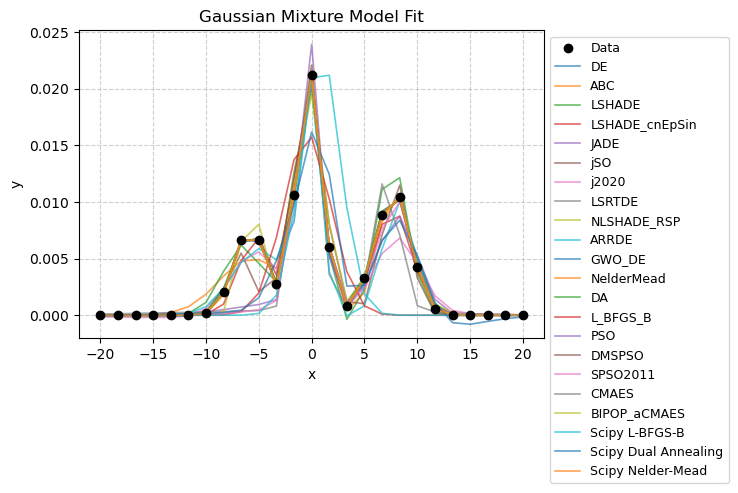

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, dual_annealing
import concurrent.futures

# Step 1: Generate Data Points from a Gaussian Mixture Model (GMM)
np.random.seed(5)  # For reproducibility

num_gauss = 5  # Number of Gaussians
true_centers = 10 * (-1 + 2 * np.random.random(num_gauss))  # Random center positions
true_widths = np.random.rand(num_gauss) + 1.0  # Widths (variances)
true_coeffs = 2.0 * np.random.rand(num_gauss)  # Coefficients

dimension = num_gauss * 3  # Total number of free parameters

# Define a Gaussian function
def gauss(x, center, width):
    """Compute a Gaussian value at x given center and width."""
    return (1.0 / (2.0 * np.pi * width ** 2)) * 0.5 * np.exp(-((x - center) ** 2) / (2 * width ** 2))

# Define the Gaussian Mixture Model (GMM)
def gmm(x, centers, widths, coeffs):
    """Evaluate the Gaussian Mixture Model (GMM) at x."""
    result = np.zeros_like(x)
    coeffs = np.array(coeffs)
    norm_coeff = coeffs / np.sum(coeffs)  # Normalize coefficients
    for i in range(len(centers)):
        result += norm_coeff[i] * gauss(x, centers[i], widths[i])
    return result

# Generate synthetic data
x_data = np.linspace(-20, 20, dimension + 10)
y_data = gmm(x_data, true_centers, true_widths, true_coeffs)

# Step 2: Define the Model for Fitting
def gmm_model(x, params):
    """Compute GMM model values for given parameters."""
    num_gauss = len(params) // 3
    centers = params[:num_gauss]
    widths = params[num_gauss:2*num_gauss]
    coeffs = params[2*num_gauss:]
    return gmm(x, centers, widths, coeffs)

# Step 3: Define the Objective Function
def objective_function(params):
    """Compute the mean squared error between model and data."""
    y_pred = gmm_model(x_data, params)
    return np.mean((y_data - y_pred) ** 2)

# Parallelized objective function
executor = concurrent.futures.ThreadPoolExecutor(max_workers=8)

def objective_function_vect(params):
    """Vectorized version of objective function using multithreading."""
    return list(executor.map(objective_function, params))

# Optimization Settings
bounds = [(-10, 10)] * dimension
Nmaxeval = 10000
algos = [
    "DE", "ABC", "LSHADE", "LSHADE_cnEpSin", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP",
        "ARRDE", "GWO_DE", "NelderMead", "DA", "L_BFGS_B", "PSO", "DMSPSO", "SPSO2011", "CMAES", "BIPOP_aCMAES"
]

x0 = [[1.0 for _ in range(dimension)]]

# Step 4: Minimize the Objective Function and Plot Results
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label="Data", color="black", marker="o", zorder=3)

print("\nOptimization Results:")
print("=" * 60)

# Run Optimization with Custom Algorithms
for algo in algos:
    res = mpy.Minimizer(
        objective_function_vect, bounds, x0=x0, relTol=0.0,
        algo=algo, maxevals=Nmaxeval, callback=None, seed=None,
        options={"population_size": 0}
    ).optimize()

    print(f"{algo:<30}: f(x) = {res.fun:<20.8g}")
    plt.plot(x_data, gmm_model(x_data, res.x), label=algo, linewidth=1.2, alpha=0.7)

# Run SciPy Optimizers
scipy_algorithms = [
    ("Scipy L-BFGS-B", minimize, {"x0": x0[0], "bounds": bounds, "method": "L-BFGS-B", "options": {"maxfun": Nmaxeval}}),
    ("Scipy Dual Annealing", dual_annealing, {"x0": x0[0],"bounds": bounds, "maxfun": Nmaxeval, "no_local_search": False}),
    ("Scipy Nelder-Mead", minimize, {"x0": x0[0],  "bounds": bounds,"method": "Nelder-Mead", "options": {"maxfev": Nmaxeval, "adaptive": True}}),
]

for name, func_opt, kwargs in scipy_algorithms:
    res = func_opt(objective_function, **kwargs)
    print(f"{name:<30}: f(x) = {res.fun:<20.8g}")
    plt.plot(x_data, gmm_model(x_data, res.x), label=name, linewidth=1.2, alpha=0.7)

print("=" * 60)

# Plot Formatting
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=9)
plt.title("Gaussian Mixture Model Fit")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

executor.shutdown()



## More complex fitting problem: CT18 PDFs Fitting

Here, we provide a slightly more challenging curve fitting problem. The task is to reproduce the CT18 parton distribution functions (PDFs) \cite{Hou:2019efy}. The parameterization for valence up-quark ($u_v$), valence down-quark ($d_v$), gluon, anti-$u$ ($\bar{u}$), anti-$d$ ($\bar{d}$), and strange quark ($s$) PDFs at the initial scale is given by:
$$
    f_i(x) = a_0 x^{a_1-1} (1-x)^{a_2} P_i(y, a_3, a_4, \dots), \quad i \in \{u_v, d_v, g, \bar{u}, \bar{d}, s\}
$$
Here, $P_i(y)$ is a Bernstein polynomial of degree 4, 3, or 5, depending on the specific PDF. The variable $y$ is defined as $y = \sqrt{x}$ for $u_v$, $d_v$, and $g$, and as $y = (1 - (1 - \sqrt{x}))^{a_3}$ for the sea quarks. The objective function is:
$$
    L = \sum_i \frac{1}{N} \sum_{j=1}^N \left(y_j - f_i(x_j)\right)^2
$$
where $i \in \{u_v, d_v, g, \bar{u}, \bar{d}, s\}$. The dimensionality of this problem is $D = 47$.


In [15]:
class CT18PDFs : 
    def __init__(self) : 
        self.parameters = {
            "uv_0" : 3.385, "uv_1" : 0.763, "uv_2" : 3.036, "uv_3" : 1.502, "uv_4" : -0.147,"uv_5" : 1.671, "uv_6" : 0.,
            "dv_0" : 0.490, "dv_1" : 0.763, "dv_2" : 3.036, "dv_3" : 2.615, "dv_4" : 1.828,"dv_5" : 2.721, "dv_6" : 0., 
            "g_0" : 2.690, "g_1" : 0.531, "g_2" : 3.148, "g_3" : 3.032, "g_4" : -1.705, "g_5" : 1.354, 
            "ubar_0" : 0.414, "ubar_1" : -0.022, "ubar_2" : 7.737, "ubar_3" : 4.0, "ubar_4" : 0.618,"ubar_5" : 0.195, "ubar_6" : 0.871, "ubar_7" : 0.267,"ubar_8" : 0.733,
            "dbar_0" : 0.414, "dbar_1" : -0.022, "dbar_2" : 7.737, "dbar_3" : 4.0, "dbar_4" : 0.292,"dbar_5" : 0.647, "dbar_6" : 0.474, "dbar_7" : 0.741,"dbar_8" :1.0,
            "s_0" : 0.288, "s_1" : -0.022, "s_2" : 10.31, "s_3" : 4.0, "s_4" : 0.466,"s_5" : 0.466, "s_6" : 0.225, "s_7" : 0.225,"s_8" : 1.0,
        }
        self.xlist = np.linspace(1e-3, 0.8, 50)
        self.paramNames = list(self.parameters.keys())
        self.originalData = self.getData()

    def uv(self, x) : 
        a0 = self.parameters["uv_0"]
        a1 = self.parameters["uv_1"]
        a2 = self.parameters["uv_2"]
        a3 = self.parameters["uv_3"]
        a4 = self.parameters["uv_4"]
        a5 = self.parameters["uv_5"]
        a6 = self.parameters["uv_6"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**4 + np.sinh(a4) *4*y*(1-y)**3 + np.sinh(a5) *6*y**2*(1-y)**2 + np.sinh(a6) *4*y**3*(1-y) + y**4
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def dv(self, x) : 
        a0 = self.parameters["dv_0"]
        a1 = self.parameters["dv_1"]
        a2 = self.parameters["dv_2"]
        a3 = self.parameters["dv_3"]
        a4 = self.parameters["dv_4"]
        a5 = self.parameters["dv_5"]
        a6 = self.parameters["dv_6"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**4 + np.sinh(a4) *4*y*(1-y)**3 + np.sinh(a5) *6*y**2*(1-y)**2 + np.sinh(a6) *4*y**3*(1-y) + y**4
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def g(self, x) : 
        a0 = self.parameters["g_0"]
        a1 = self.parameters["g_1"]
        a2 = self.parameters["g_2"]
        a3 = self.parameters["g_3"]
        a4 = self.parameters["g_4"]
        a5 = self.parameters["g_5"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**3 + np.sinh(a4) *3*y*(1-y)**2 + np.sinh(a5) *3*y**2*(1-y)  + y**3
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def ubar(self, x) : 
        a0 = self.parameters["ubar_0"]
        a1 = self.parameters["ubar_1"]
        a2 = self.parameters["ubar_2"]
        a3 = self.parameters["ubar_3"]
        a4 = self.parameters["ubar_4"]
        a5 = self.parameters["ubar_5"]
        a6 = self.parameters["ubar_6"]
        a7 = self.parameters["ubar_7"]
        a8 = self.parameters["ubar_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def dbar(self, x) : 
        a0 = self.parameters["dbar_0"]
        a1 = self.parameters["dbar_1"]
        a2 = self.parameters["dbar_2"]
        a3 = self.parameters["dbar_3"]
        a4 = self.parameters["dbar_4"]
        a5 = self.parameters["dbar_5"]
        a6 = self.parameters["dbar_6"]
        a7 = self.parameters["dbar_7"]
        a8 = self.parameters["dbar_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def s(self, x) : 
        a0 = self.parameters["s_0"]
        a1 = self.parameters["s_1"]
        a2 = self.parameters["s_2"]
        a3 = self.parameters["s_3"]
        a4 = self.parameters["s_4"]
        a5 = self.parameters["s_5"]
        a6 = self.parameters["s_6"]
        a7 = self.parameters["s_7"]
        a8 = self.parameters["s_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def u(self, x) : return self.uv(x)+self.ubar(x)
    def d(self, x) : return self.dv(x)+self.dbar(x) 

    def setParameter(self, pars) : 
        assert(len(pars)==len(self.parameters)) 
        self.parameters= dict(zip(self.paramNames, pars))

    def getData(self) : 
        x= self.xlist
        return [ x*self.u(self.xlist), x*self.ubar(self.xlist), x*self.d(self.xlist), x*self.dbar(self.xlist), x*self.g(self.xlist), x*self.s(self.xlist)]
    
    def objective_function(self, params): 
        self.setParameter(params) 
        data = self.getData() 
        ret =0
        for do, d in zip(self.originalData, data) : 
            ret = ret + np.sum((do-d)**2)
        return ret

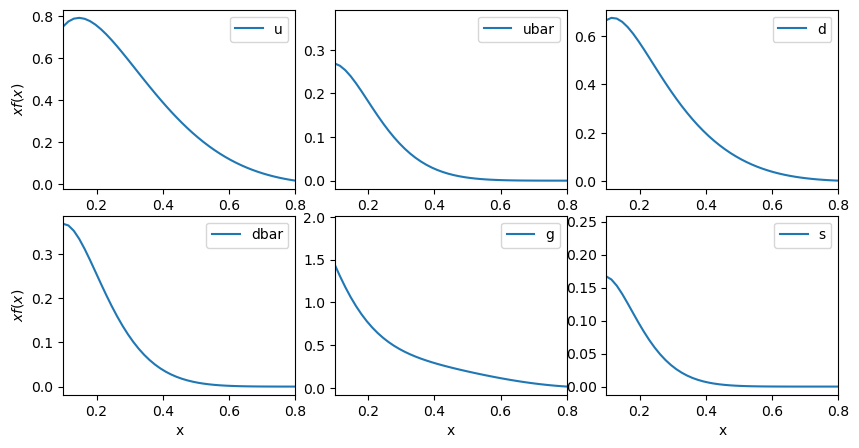

In [16]:
ct18 = CT18PDFs()
data = ct18.getData()
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

# List of labels for each plot
labels = ["u", "ubar", "d", "dbar", "g", "s"]

# Plotting each function in its corresponding subplot
for i, ax in enumerate(axes.flatten()):
    ax.plot(ct18.xlist, data[i], label=labels[i])
    ax.set_xlim(0.1, 0.8)
    ax.set_xlabel("x")
    if (i%3 == 0):
        ax.set_ylabel(r"$xf(x)$")
    ax.legend()
plt.subplots_adjust(hspace=0.15, wspace=0.17)
plt.show()


Dimension: 47

Optimization Results:
DE                            : f(x) = 0.19269741          
ABC                           : f(x) = 9.2305563           
LSHADE                        : f(x) = 5.0262623           
LSHADE_cnEpSin                : f(x) = 0.34919775          
JADE                          : f(x) = 4.6637756           
jSO                           : f(x) = 0.78116151          
j2020                         : f(x) = 9.9470365           
LSRTDE                        : f(x) = 0.39744395          
NLSHADE_RSP                   : f(x) = 1.0981858           
ARRDE                         : f(x) = 1.2748372           
GWO_DE                        : f(x) = 1.8577235           
NelderMead                    : f(x) = 0.072777402         
DA                            : f(x) = 0.13416323          
L_BFGS_B                      : f(x) = 0.019077562         
PSO                           : f(x) = 0.055286483         
DMSPSO                        : f(x) = 0.327826            
SPS

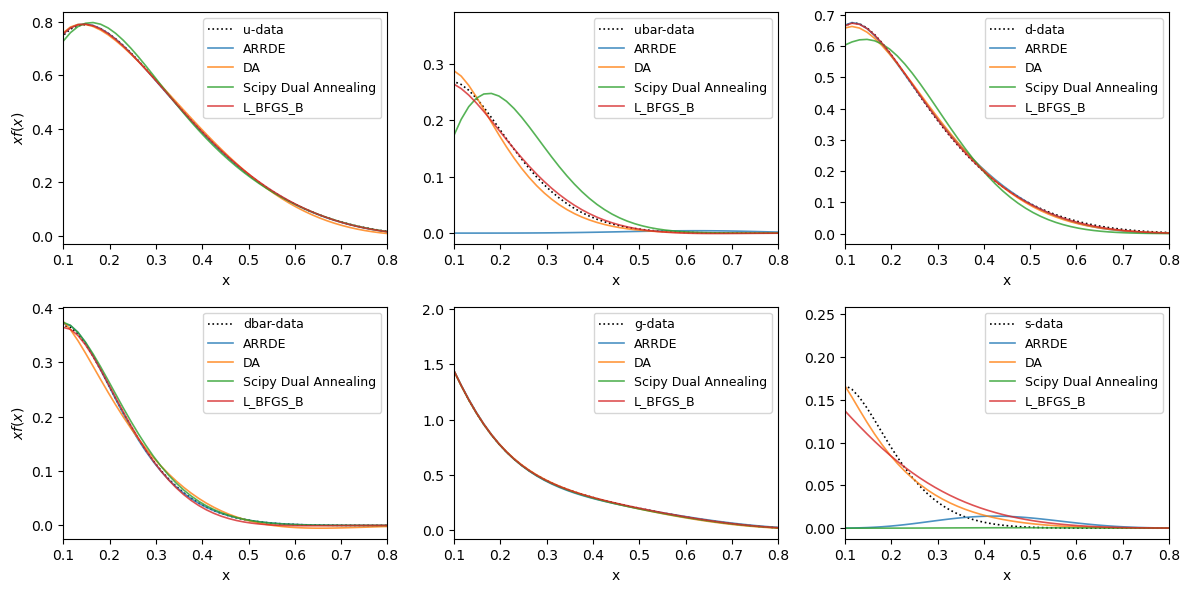

In [17]:
# Step 1: Define Problem Dimensions and Settings
dimension = 47
print("Dimension:", dimension)

bounds = [(-10, 10)] * dimension
Nmaxeval = 100000
x0 = [[1.0] * dimension]  # Initial guess

# Step 2: Set Up Parallel Execution for CT18PDFs
t_parallel = mpy.Thread_Parallel(4, CT18PDFs)  # Vectorize using 4 threads

# Step 3: Define Optimization Algorithms
algos = [
   "DE", "ABC", "LSHADE", "LSHADE_cnEpSin", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP",
        "ARRDE", "GWO_DE", "NelderMead", "DA", "L_BFGS_B", "PSO", "DMSPSO", "SPSO2011", "CMAES", "BIPOP_aCMAES"
]

# Step 4: Run Optimization and Collect Results
results = {}

print("\nOptimization Results:")
print("=" * 60)

for algo in algos:
    res = mpy.Minimizer(
        t_parallel, bounds, x0=x0, algo=algo, relTol=0.0,
        maxevals=Nmaxeval, callback=None, seed=None,
        options={
            "population_size": 0,
            "func_noise_ratio"  :  0.0, 
            "N_points_derivative": 1
        }
    ).optimize()

    print(f"{algo:<30}: f(x) = {res.fun:<20.8g}")
    results[algo] = res

# Step 5: Run SciPy Optimizers
scipy_algorithms = [
    ("Scipy L-BFGS-B", minimize, {"x0": x0[0], "bounds": bounds, "method": "L-BFGS-B", "options": {"maxfun": Nmaxeval}}),
    ("Scipy Dual Annealing", dual_annealing, {"x0": x0[0],"bounds": bounds, "maxfun": Nmaxeval, "no_local_search": False}),
    ("Scipy Nelder-Mead", minimize, {"x0": x0[0],  "bounds": bounds,"method": "Nelder-Mead", "options": {"maxfev": Nmaxeval, "adaptive": True}}),
]

for name, func_opt, kwargs in scipy_algorithms:
    res = func_opt(ct18.objective_function, **kwargs)
    print(f"{name:<30}: f(x) = {res.fun:<20.8g}")
    results[name] = res

print("=" * 60)

# Step 6: Plot Results
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
labels = ["u-data", "ubar-data", "d-data", "dbar-data", "g-data", "s-data"]

# Plot each dataset in its corresponding subplot
for i, ax in enumerate(axes.flatten()):
    ax.plot(ct18.xlist, data[i], label=labels[i], color="black", linestyle="dotted", linewidth=1.2)

    # Overlay model predictions for selected algorithms
    for algo in ["ARRDE", "DA", "Scipy Dual Annealing", "L_BFGS_B"]:
        ct18.setParameter(results[algo].x)
        theo = ct18.getData()
        ax.plot(ct18.xlist, theo[i], label=algo, linewidth=1.2, alpha=0.8)

    ax.set_xlim(0.1, 0.8)
    ax.set_xlabel("x")
    if i % 3 == 0:
        ax.set_ylabel(r"$xf(x)$")
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

